Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch 1/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1817542528.0000 - val_loss: 1824271744.0000 - learning_rate: 0.0010
Epoch 2/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1829992832.0000 - val_loss: 1823917568.0000 - learning_rate: 0.0010
Epoch 3/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1820283392.0000 - val_loss: 1823438464.0000 - learning_rate: 0.0010
Epoch 4/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1816273664.0000 - val_loss: 1822612480.0000 - learning_rate: 0.0010
Epoch 5/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1815637760.0000 - val_loss: 1821720064.0000 - learning_rate: 0.0010
Epoch 6/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1816695168.0000 - val_loss: 1820750976.0000 - learning_rate: 0.0010
Epoch 7/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1820530816.0000 - val_loss: 1819229184.0000 - learning_rate: 0.0010
Epoch 8/1000
113/113 ━━━━━━━━

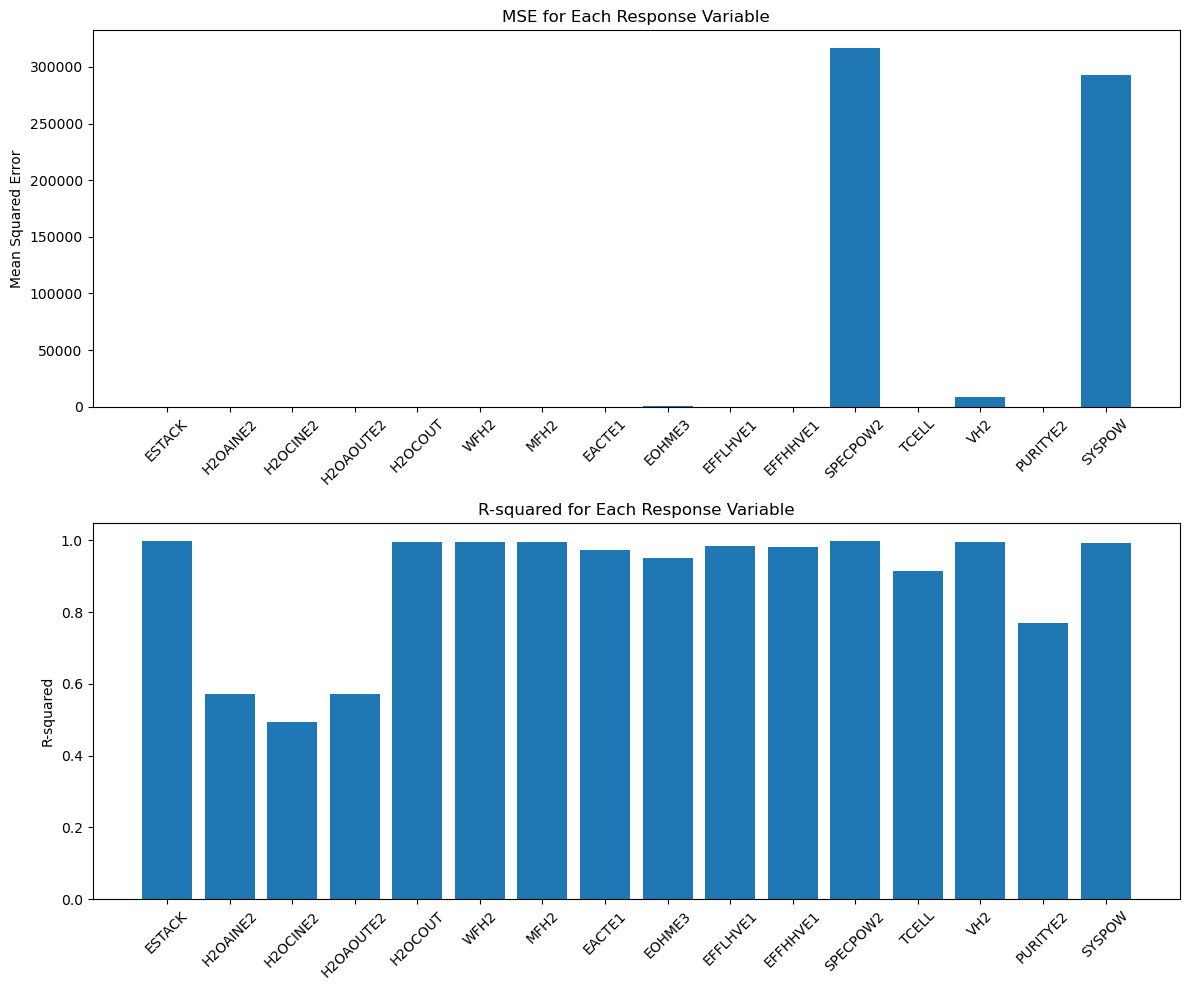

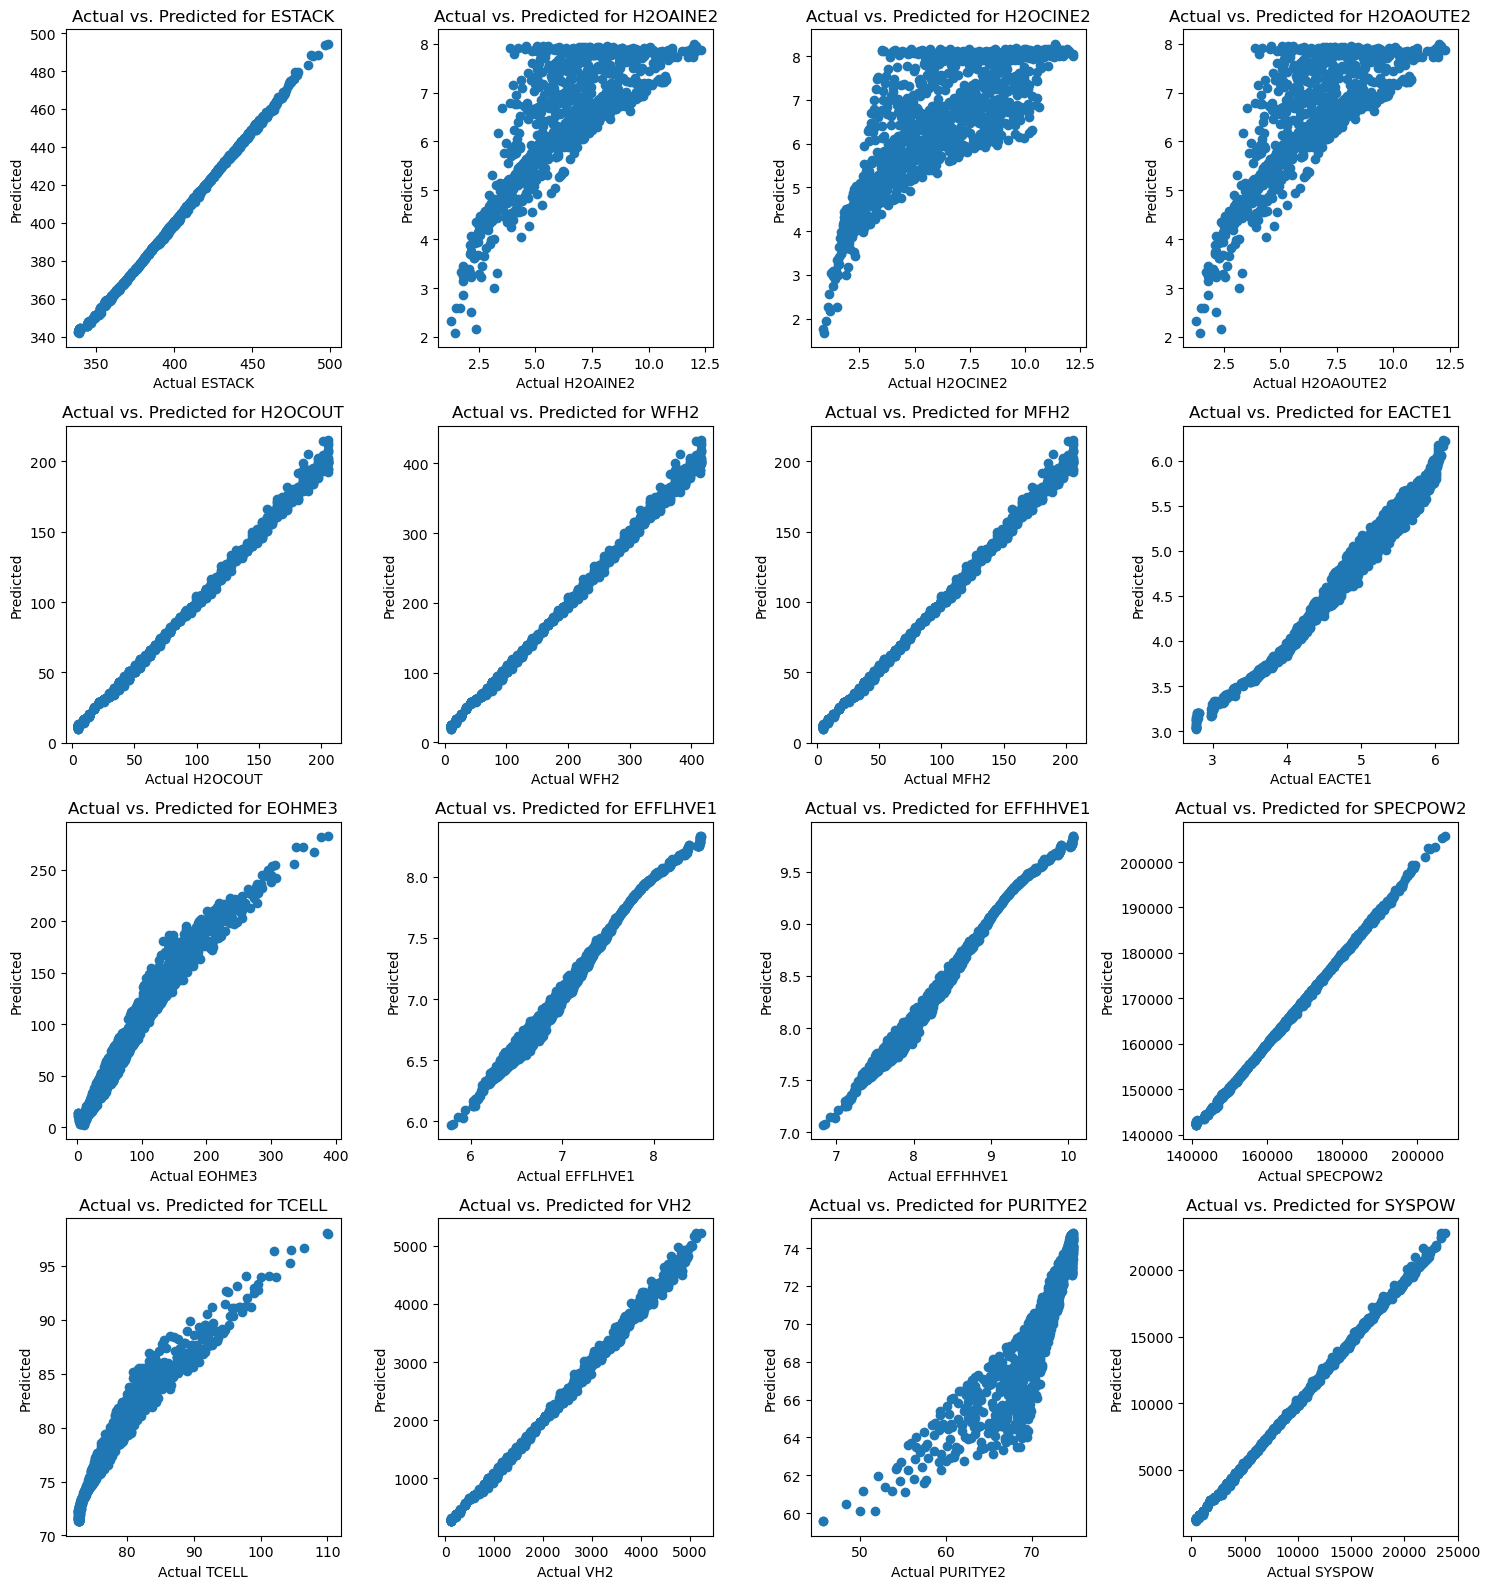

KeyError: 'loss'

<Figure size 800x600 with 0 Axes>

In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Set environment variable to UTF-8
os.environ['PYTHONIOENCODING'] = 'UTF-8'

# 1. Data Preparation
df = pd.read_csv('full result clean.csv', header=1, encoding='utf-8')

df.drop(index=0, inplace=True)

df.columns = ['V1', 'V2', 'V3E4', 'ESTACK', 'H2OAINE2', 'H2OCINE2', 'H2OAOUTE2',
              'H2OCOUT', 'WFH2', 'MFH2', 'EACTE1', 'EOHME3', 'EFFLHVE1', 'EFFHHVE1',
              'SPECPOW2', 'TCELL', 'VH2', 'PURITYE2', 'SYSPOW']

X = df[['V1', 'V2', 'V3E4']]
y = df.drop(columns=['V1', 'V2', 'V3E4'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Improved Model Creation
def create_model(num_layers=2, neurons=64, dropout_rate=0.2, batch_size=32):
    try:
        input_layer = Input(shape=(3,))
        x = input_layer
        for _ in range(num_layers):
            x = Dense(neurons, activation='relu', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        output_layer = Dense(y.shape[1])(x)  # Output layer for multiple targets
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(), loss='mse')
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None
    finally:
        # Clear the Keras session to avoid memory issues
        from tensorflow.keras import backend as K
        K.clear_session()

# 3. Pipeline (with Hyperparameter Tuning)
model = KerasRegressor(
    model=create_model,  # Pass the function
    epochs=1000,
    batch_size=32, 
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)]
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

# Hyperparameter Tuning Configuration (Corrected)
param_distributions = {
    # Use model__ prefix to indicate parameters for the KerasRegressor
    'model__model__num_layers': [4, 5],      
    'model__model__neurons': [32, 64, 128], 
    'model__model__dropout_rate': [0.1, 0.2, 0.3],
    'model__model__batch_size': [32, 64]
}

# Randomized Search (Corrected)
random_search = RandomizedSearchCV(
    estimator=pipeline,            # Pass the pipeline estimator
    param_distributions=param_distributions,  # Pass the parameter distributions
    n_iter=20, 
    scoring='neg_mean_squared_error',
    cv=3, 
    n_jobs=-1,
    verbose=2,
    error_score='raise'  
)
try:
    random_search.fit(X_train, y_train)
    best_pipeline = random_search.best_estimator_  # Assign only if successful

    # 5. Model Evaluation on the Test Set
    y_pred = best_pipeline.predict(X_test)

    # ... (rest of your evaluation and visualization code)

except ValueError as ve:
    print("ValueError during RandomizedSearchCV fit:", ve)
    # Analyze the specific error raised to get more insights

    # If the fit fails, don't proceed with evaluation and visualization
    print("Model fitting failed. Evaluation and visualization skipped.")

# 5. Model Evaluation on the Test Set
y_pred = best_pipeline.predict(X_test)


# 6. Individual Metrics Calculation and Visualization
mse_values = {}
r2_values = {}
for col in y_test.columns: 
    mse_values[col] = mean_squared_error(y_test[col], y_pred[:, y_test.columns.get_loc(col)])
    r2_values[col] = r2_score(y_test[col], y_pred[:, y_test.columns.get_loc(col)])

    print(f'Metrics for {col}:')
    print(f'  Mean Squared Error: {mse_values[col]}')
    print(f'  R-squared: {r2_values[col]}')


# Visualization (Bar Charts)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
axes[0].bar(mse_values.keys(), mse_values.values())
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE for Each Response Variable')
axes[0].tick_params(axis='x', rotation=45)  

axes[1].bar(r2_values.keys(), r2_values.values())
axes[1].set_ylabel('R-squared')
axes[1].set_title('R-squared for Each Response Variable')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Visualization (Scatter Plots - Actual vs. Predicted)
num_rows = int(np.ceil(len(y_test.columns) / 4))  
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(15, 4 * num_rows))

for i, col in enumerate(y_test.columns):
    row = i // 4
    col_index = i % 4
    axes[row, col_index].scatter(y_test[col], y_pred[:, y_test.columns.get_loc(col)])  # Use get_loc()
    axes[row, col_index].set_xlabel(f'Actual {col}')
    axes[row, col_index].set_ylabel('Predicted')
    axes[row, col_index].set_title(f'Actual vs. Predicted for {col}')

plt.tight_layout()
plt.show()

# Learning Curves
best_model = best_pipeline.named_steps['model'].model_
history = best_model.history.history

plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
